In [1]:
from importlib import reload
import utils; reload(utils)
from utils import *
data_path =  '/Volumes/Backups/data/LUNA16/patches/'

Using cuDNN version 5105 on context None
Preallocating 2867/4095 Mb (0.700000) on cuda0
Mapped name None to device cuda0: GeForce GTX 650 (0000:01:00.0)
Using Theano backend.


In [2]:
%matplotlib inline
import os, random
from shutil import copytree
data_path =  '/Volumes/Backups/data/LUNA16/patches/'

In [3]:
theano.config.dnn.conv.precision = 'float32'
print(theano.config.dnn.conv.precision)

float32


In [4]:
#for i in range(10):
#    patches1 = random.choice(os.listdir("/Volumes/Backups/data/LUNA16/patches/patches1/"))
#    patches0 = random.choice(os.listdir("/Volumes/Backups/data/LUNA16/patches/patches0/"))
#    copytree(data_path + 'patches1/' + patches1, '/Volumes/Backups/data/LUNA16/patches/sample/patches1/' + patches1)
#    copytree(data_path + 'patches0/' + patches0, '/Volumes/Backups/data/LUNA16/patches/sample/patches0/' + patches0)
#    

In [5]:
import numpy as np
np.set_printoptions(precision=4,linewidth=100)
import pandas as pd
from vgg16bn import Vgg16BN

In [6]:
model = vgg_ft_bn(2)

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


GraphToGPU convolution2d_1_W convolution2d_1_W
GraphToGPU convolution2d_2_W convolution2d_2_W
GraphToGPU convolution2d_3_W convolution2d_3_W
GraphToGPU convolution2d_4_W convolution2d_4_W
GraphToGPU convolution2d_5_W convolution2d_5_W
GraphToGPU convolution2d_6_W convolution2d_6_W
GraphToGPU convolution2d_7_W convolution2d_7_W
GraphToGPU convolution2d_8_W convolution2d_8_W
GraphToGPU convolution2d_9_W convolution2d_9_W
GraphToGPU convolution2d_10_W convolution2d_10_W
GraphToGPU convolution2d_11_W convolution2d_11_W
GraphToGPU convolution2d_12_W convolution2d_12_W
GraphToGPU convolution2d_13_W convolution2d_13_W
GraphToGPU DotModulo.0 DotModulo.0
local_cut_gpu_transfers HostFromGpu(gpuarray).0 A
local_cut_gpu_transfers HostFromGpu(gpuarray).0 s
local_cut_gpu_transfers HostFromGpu(gpuarray).0 A2
local_cut_gpu_transfers HostFromGpu(gpuarray).0 s2


In [7]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(2)


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


GraphToGPU convolution2d_14_W convolution2d_14_W
GraphToGPU convolution2d_15_W convolution2d_15_W
GraphToGPU convolution2d_16_W convolution2d_16_W
GraphToGPU convolution2d_17_W convolution2d_17_W
GraphToGPU convolution2d_18_W convolution2d_18_W
GraphToGPU convolution2d_19_W convolution2d_19_W
GraphToGPU convolution2d_20_W convolution2d_20_W
GraphToGPU convolution2d_21_W convolution2d_21_W
GraphToGPU convolution2d_22_W convolution2d_22_W
GraphToGPU convolution2d_23_W convolution2d_23_W
GraphToGPU convolution2d_24_W convolution2d_24_W
GraphToGPU convolution2d_25_W convolution2d_25_W
GraphToGPU convolution2d_26_W convolution2d_26_W


In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
GraphToGPU Shape.0 Shape.0
GraphToGPU Shape.0 Shape.0
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
_____________________________________

In [9]:
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
from skimage import color

In [11]:
np.sctypes

{'complex': [numpy.complex64, numpy.complex128, numpy.complex256],
 'float': [numpy.float16, numpy.float32, numpy.float64, numpy.float128],
 'int': [numpy.int8, numpy.int16, numpy.int32, numpy.int64],
 'others': [bool, object, bytes, str, numpy.void],
 'uint': [numpy.uint8, numpy.uint16, numpy.uint32, numpy.uint64]}

In [12]:
np_img = np.zeros((1,224,224))

In [13]:
np_img


array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [14]:
import glob2
image_labels = []
img_array = np.zeros((1,3,224,224),dtype=np.float32)
print(type(img_array[0][0][0][0]))
i=0
#for filename in glob2.glob(data_path+'sample/*/*'):
for filename in (os.listdir(data_path + "sample/")):
    print(filename)
    for image in  glob2.glob(data_path + "sample/" + filename+'/*'):
        if (filename == 'patches0'):
            image_labels.append(np.int16(0.0))
            print(type(image_labels[0]))
        else:
            image_labels.append(np.int16(1.0))
        print ("imagename: " + image)
        img = color.gray2rgb(load_array(image)).astype(np.float32)
        print("img type: " + str(type(img[0][0][0])))
        np_img = np.transpose(np.asarray(img,dtype=np.float32),(2,0,1))
        print(np_img.shape)
        print("np_img type : " + str(type(np_img[0][0][0])))
        tmp_img = np.zeros((1,3,224,224),dtype=np.float32)
        print(tmp_img.shape)
        print("tmp_img type : " + str(type(tmp_img[0][0][0][0])))
        tmp_img[0] = np_img
        print("np.shape: " + str(tmp_img.shape))
        img_array = np.concatenate((img_array, tmp_img))
        print("img_array.shape :" + str(img_array.shape))
        i += 1
img_array = img_array[1:]



<class 'numpy.float32'>
patches0
<class 'numpy.int16'>
imagename: /Volumes/Backups/data/LUNA16/patches/sample/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866_57569_224x224.bc
img type: <class 'numpy.float32'>
(3, 224, 224)
np_img type : <class 'numpy.float32'>
(1, 3, 224, 224)
tmp_img type : <class 'numpy.float32'>
np.shape: (1, 3, 224, 224)
img_array.shape :(2, 3, 224, 224)
<class 'numpy.int16'>
imagename: /Volumes/Backups/data/LUNA16/patches/sample/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_332005_224x224.bc
img type: <class 'numpy.float32'>
(3, 224, 224)
np_img type : <class 'numpy.float32'>
(1, 3, 224, 224)
tmp_img type : <class 'numpy.float32'>
np.shape: (1, 3, 224, 224)
img_array.shape :(3, 3, 224, 224)
<class 'numpy.int16'>
imagename: /Volumes/Backups/data/LUNA16/patches/sample/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386_390803_224x224.bc
img type: <class 'numpy.float32'>
(3, 224, 224)
np_img 

In [15]:
print(type(np_img[0][0][0]))

<class 'numpy.float32'>


In [16]:
 img_array.shape

(82, 3, 224, 224)

In [17]:
img.shape

(224, 224, 3)

In [18]:
type(img[0][0][0])

numpy.float32

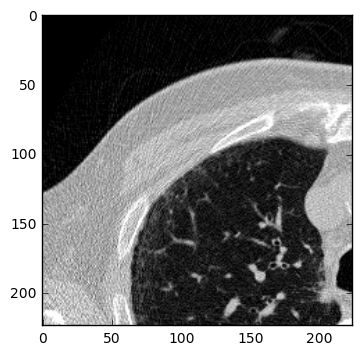

In [19]:
plt.imshow(img_array[13][2],cmap=plt.cm.gray)

In [20]:
type(img_array[0][0][0][0])

numpy.float32

In [21]:
len(image_labels)

82

In [22]:
type(image_labels[19])

numpy.int16

In [23]:
ohe_image_labels = to_categorical(np.array(np.float32(image_labels))).astype(np.float32)

In [24]:
type(ohe_image_labels[0][0])

numpy.float32

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
trn_labels, val_labels = train_test_split(ohe_image_labels, test_size=0.2, random_state=42)

In [27]:
trn,val = train_test_split(img_array, test_size=0.2, random_state=42,)

In [28]:
trn.shape

(65, 3, 224, 224)

In [29]:
type(val[0][0][1][0])

numpy.float32

In [30]:
batch_size = 4

In [31]:
type(val[1][0][1][0])

numpy.float32

In [32]:
model.fit(trn, 
          trn_labels, 
          batch_size=batch_size, 
          nb_epoch=1, 
          validation_data=(val, val_labels),verbose = 1)


MergeOptimizer Constant{0} Constant{0}
MergeOptimizer Constant{0} Constant{0}
MergeOptimizer Constant{0} Constant{0}
MergeOptimizer Constant{0} Constant{0}
MergeOptimizer Shape.0 Shape.0
MergeOptimizer Subtensor{int64}.0 Subtensor{int64}.0
MergeOptimizer Shape.0 Shape.0
MergeOptimizer TensorConstant{(2,) of 0} TensorConstant{(2,) of 0}
MergeOptimizer TensorConstant{(2,) of 2} TensorConstant{(2,) of 2}
MergeOptimizer TensorConstant{(2,) of 2} TensorConstant{(2,) of 2}
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{0} Constant{0}
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{2} Constant{2}
MergeOptimizer Constant{3} Constant{3}
MergeOptimizer Constant{2} Constant{2}
MergeOptimizer Subtensor{int64}.0 Subtensor{int64}.0
MergeOptimizer Elemwise{add,no_inplace}.0 Elemwise{add,no_inplace}.0
MergeOptimizer Constant{3} Constant{3}
MergeOptimizer Subtensor{int64}.0 Subtensor{int64}.0
MergeOptimizer Elemwise{add,no_inplace}.0

In [33]:
model.save_weights(data_path+'results/ft1.h5')

In [34]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [35]:
conv_layers

In [36]:
conv_model = Sequential(conv_layers)

In [37]:
%time conv_val_feat = conv_model.predict(val)

MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{0} Constant{0}
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{2} Constant{2}
MergeOptimizer Constant{3} Constant{3}
MergeOptimizer Constant{2} Constant{2}
MergeOptimizer Subtensor{int64}.0 Subtensor{int64}.0
MergeOptimizer Elemwise{add,no_inplace}.0 Elemwise{add,no_inplace}.0
MergeOptimizer Constant{3} Constant{3}
MergeOptimizer Subtensor{int64}.0 Subtensor{int64}.0
MergeOptimizer Elemwise{add,no_inplace}.0 Elemwise{add,no_inplace}.0
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{0} Constant{0}
MergeOptimizer Constant{1} Constant{1}
MergeOptimizer Constant{2} Constant{2}
MergeOptimizer Constant{3} Constant{3}
MergeOptimizer Constant{2} Constant{2}
MergeOptimizer Subtensor{int64}.0 Subtensor{int64}.0
MergeOptimizer Elemwise{add,no_inplace}.0 Elemwise{add,no_inplace}.0
MergeOptimizer Constant{3} Constant{3}
MergeOptim

In [38]:
conv_val_feat.shape

(17, 512, 14, 14)

In [39]:
%time conv_feat = conv_model.predict(trn)

CPU times: user 7.96 s, sys: 75.4 ms, total: 8.03 s
Wall time: 8.13 s


In [ ]:
print(theano.config)

In [ ]:
theano.config.dnn.conv.precision = 'float32'

In [ ]:
print(theano.config)